In [2]:
import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import glob
import os
from skimage import io
import random
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
  Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Preparing metadata (setup.py) ... done
  Using cached safetensors-0.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4665c82ee80fd04aff6a23468fad9ab94df101eb019d36e986839038298177b7
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=585a67ee3ccc93cae308bb546d82a143dc52078438ef96b8ba700eafdbf0b36d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built 

In [3]:
class DeepLabMobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.deeplab = smp.DeepLabV3Plus(encoder_name="mobilenet_v2", in_channels=3, classes=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.deeplab(x)
        x = self.sigmoid(x)
        return x

In [4]:
class MyDataset(data.Dataset):
    def __init__(self, mode, transform, val_size):
        super().__init__()
        self.transform = transform
        self.mode = mode
        all_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*.tif', recursive=True)
        masked_paths = glob.glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*mask.tif', recursive=True)
        real_paths = [x for x in all_paths if x not in masked_paths]
        masked_paths.sort()
        real_paths.sort()
        random.Random(0).shuffle(masked_paths)
        random.Random(0).shuffle(real_paths)
        if mode == 'train':
            self.masked_paths = masked_paths[0: int(len(masked_paths) * (1 - val_size))]
            self.real_paths = real_paths[0: int(len(real_paths) * (1 - val_size))]
        elif mode == 'val':
            self.masked_paths = masked_paths[int(len(masked_paths) * (1 - val_size)): ]
            self.real_paths = real_paths[int(len(real_paths) * (1 - val_size)): ]

    def __getitem__(self, index):
        img = io.imread(self.real_paths[index])
        img = self.transform(img)
        mask = io.imread(self.masked_paths[index])
        mask = self.transform(mask)
        return img.float(), mask.float()

    def __len__(self):
        return len(self.masked_paths)

In [5]:
class Dice(nn.Module):
    def __init__(self, eps=0):
        super().__init__()
        self.eps = eps

    def forward(self, pred, y_true):
        intersection = 2.0 * torch.sum(pred * y_true) + self.eps
        union = torch.sum(y_true + pred) + self.eps
        return 1 - (intersection / union)

In [6]:
dice_loss = Dice(eps=1)
batch_size = 64
learning_rate = 0.001
num_epochs = 10
val_size = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
model = DeepLabMobileNet()
model = model.to(device)
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
train_dataset = MyDataset('train', train_transform, val_size)
val_dataset = MyDataset('val', val_transform, val_size)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [8]:
for epoch in range(1, num_epochs + 1):
    print('epoch:', epoch)
    model.train()
    for reals, masks in train_loader:
        reals = reals.to(device)
        masks = masks.to(device)
        preds = model(reals)
        loss = dice_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
    
    model.eval() 
    with torch.no_grad():
        for mode, loader in zip(['train', 'val'], [train_loader, val_loader]):
            epoch_metric, num_samples = 0, 0
            for reals, masks in loader:
                reals = reals.to(device)
                masks = masks.to(device)
                preds = model(reals)
                preds[preds >= 0.5] = 1.0
                preds[preds < 0.5] = 0.0
                dice = 1 - dice_loss(preds, masks)
                epoch_metric += dice.item() * masks.shape[0] 
                num_samples += masks.shape[0]

            epoch_metric = epoch_metric / num_samples
            print(mode, '- loss:', f'{epoch_metric:.2}')

epoch: 1
train - loss: 0.59
val - loss: 0.6
epoch: 2
train - loss: 0.68
val - loss: 0.7
epoch: 3
train - loss: 0.73
val - loss: 0.74
epoch: 4
train - loss: 0.74
val - loss: 0.74
epoch: 5
train - loss: 0.75
val - loss: 0.75
epoch: 6
train - loss: 0.74
val - loss: 0.74
epoch: 7
train - loss: 0.74
val - loss: 0.74
epoch: 8
train - loss: 0.76
val - loss: 0.75
epoch: 9
train - loss: 0.76
val - loss: 0.75
epoch: 10
train - loss: 0.77
val - loss: 0.76


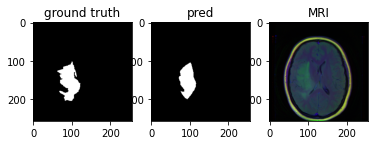

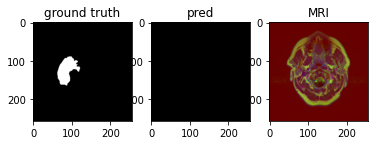

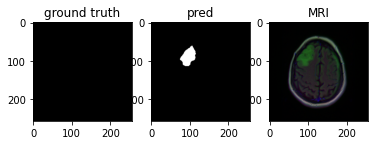

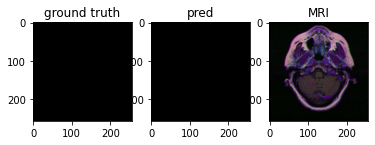

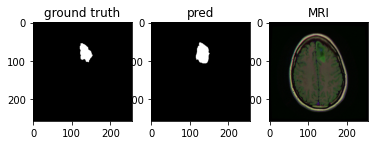

In [9]:
samples, masks = next(iter(val_loader))
samples = samples[0: 5]
masks = masks[0: 5]
samples = samples.to(device)
preds = model(samples)
preds = preds.permute(0, 2, 3, 1).detach().cpu().numpy()
masks = masks.permute(0, 2, 3, 1).detach().cpu().numpy()
samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
preds[preds >= 0.5] = 1.0
preds[preds < 0.5] = 0.0

for i in range(5):
    fig, ax = plt.subplots(1, 3)
    ax[0].set_title('ground truth')
    ax[0].imshow(masks[i], cmap='gray')
    ax[1].set_title('pred')
    ax[1].imshow(preds[i], cmap='gray')
    ax[2].set_title('MRI')
    ax[2].imshow(samples[i])
    
fig.show()    